# MIE1624: Assignment 1 by Zain Nasrullah (998892685)

# 0.0 Preparation

Note: It's probably not a good idea to run all cells because the hyperparameter tuning in the bonus section can take 1+ hours.

### 0.1 Libraries

In [4]:
# Basics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Cleaning
try:
    from bs4 import BeautifulSoup
except:
    ! pip install beautifulsoup4 
import re
from nltk.corpus import stopwords
import nltk
nltk.download("stopwords")


#Modelling
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.utils import shuffle

# Bonus
from sklearn.grid_search import GridSearchCV
from sklearn.pipeline import Pipeline

from sklearn.feature_extraction.text import TfidfVectorizer

# Other Options
pd.set_option('display.max_colwidth', -1)
pd.options.display.max_rows = 999
%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\zainn\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### 0.2 Reading in the Data

Loading in the data as a dataframe. This makes it easier to view and manipulate the data taking advantage of the benefits offered via Pandas. In particular, I will make frequently use of the .apply() method. I opted for a dataframe over a data series as columns will need to be added in the future. 

In [5]:
# Load in the data
tweets = pd.read_table('unclassified_tweets.txt', header = None)
tweets.columns = ["tweets"]
print("Number of tweets:",tweets.shape[0])
tweets.head()

Number of tweets: 3026


,tweets
0,living the dream. #cameraman #camera #cameraception #camera #cameras #marriott #feet #tommulcair… instagram.com/p/8up9qepkxw/
1,justin #trudeau's reasons for thanksgiving. today's montreal@themoment blog at bit.ly/1jqkfwr #elxn42 poll #quebec #montreal
2,@themadape butt…..butt…..we’re allergic to latex! makes us sneeze this in #nbpoli #cdnpoli pic.twitter.com/ta0llla4jk
3,2 massive explosions at peace march in #turkey. 30 killed. turkey continues to implode in violence. #cdnpoli twitter.com/telegraph/status/652800836720922624 …
4,#mulcair suggests there’s bad blood between him and #trudeau worldwideherald.com/bammt #ready4change #ndp pic.twitter.com/zgxmwo2gjk


# 1.0 Cleaning the Data

Below, I've defined a function that performs all cleaning operations and then applied that function to each tweet in the dataframe.    
   
### 1.1 Cleaning up HTML
I used BeautifulSoup's get_text() method to completely remove all HTML entities from the text. This seemed to work out well in my test cases and also converted all html character codes to their ASCII equivalent. A lot of value gained out of this library as it performs several multi-step operations via one line of code.

### 1.2 Removing URLs
I used regular expressions to remove URLs from each tweet. This made sense as the standard for a URL is generally fairly consistent; however, I soon discovered that there was significant variance in terms of how they were presented. In many cases, the "https" term was omitted and sometimes the there was no forward slash following the link (eg. google.com). To get around this, I used the code in the following cell to identify all of the unique top-level domain names used in each link:


In [6]:
# Check to see top-level domain names
def find_domains(df, col):
    domains = []
    for tweet in tweets['tweets']:
        if re.search("\.\w+", tweet):
            domain = re.search('\.(\w\w\w?)/', tweet)
            if domain is not None:
                domains.append(domain.group(1))

    domains_unique = pd.Series(domains).unique()
    return "|".join(domains_unique)

domains_string = find_domains(tweets, 'tweets')
domains_string

'com|ly|net|ca|me|is|it|by|be|tt|to|st|org|pn|es|gl|sh|uk|li|al|rs|co|ms|edu|bz|in|sx|ph|tv|gs|ru|gd'

Using the printout above, I was able to find suspected frequent domain names which will be used in a regular expression to find URLs. I have also added some more domain names such as .gov to make the code more robust (see below). The benefit of this approach is that it is more reliable for this particular dataset than an alternative as it can capture any url containing these domain names. In doing so, it can avoid errors where tweets containing improper punctuation can mimic a URL format (eg. yeah.lol). The tradeoff however is that this method would not generalize well to other datasets where the domain names may be more unique or different. The other con is that as this was a manual identification process, it is possible that I may have missed some domain names. For the purposes of this assignment however, I think the approach taken is sufficient.

### 1.3 Lower-Case
Simply used the lower method belonging to strings.

### 1.4 Empty Tweets
Empty tweets are preserved as empty.

### 1.5 Stopwords
I used nltk's standard list of stopwords for the English language and list comprehension to filter out stop words. Stopwords are words that do not add any direct meaning/interpreation of a sentence. Some examples include:

In [7]:
stopwords.words('english')[0:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your']

The above words mainly serve to identify subjects in the sentence and do not describe tone. For sentiment analysis, these words can be considered as noise as they neither describe the positive or negative sentiment captured in a tweet. Given the bag of words model where each word corresponds to a feature, including these words would unnecessarily increase noise and computational intensity. In a ML context, each stopword is a feature that we suspect is not correlated with our target variable and hence is excluded from the model. The nltk stop word list comprehensively removes these common stopwords. An alternative methodology would be to look at the most frequent words in our dataset and manually identify the stop words. The benefit of doing this is that it would account for online 'slang' and terminology that would be missing in something like nltk; however, it would require a significant manual effort time investment for potentially minimal reward. 

To summarize the cell below, the clean function takes in a string as input and then processes it. The output is a cleaned string. This function is applied to each tweet in the dataframe.

In [8]:
def clean(text, domain_string, removeStop = True, stop=stopwords.words('english')):
    '''
    Remove all HTML entities including tags+attributes and replace all html character codes by their ASCII equivalent.
    Remove all URLs
    Return lower case processed string
    '''
    # Remove HTML
    removed_html = BeautifulSoup(text, "lxml").get_text()
    
    # Remove URL
    regex = r"\S+\.(" + domain_string + ")/?\S*"
    removed_url = re.sub(regex, "", removed_html)
            
    # Convert to lower-case
    lower_string = removed_url.lower()
    
    # Remove stop words
    if removeStop is True:
        string_list = lower_string.split(" ")
        final = " ".join([item for item in string_list if item not in stop])
    else:
        final = lower_string
    
    return final

stop_words = stopwords.words('english')
tweets['tweets'] = tweets['tweets'].apply(clean, domain_string =domains_string, stop = stop_words)

In [9]:
tweets.head()

,tweets
0,living dream. #cameraman #camera #cameraception #camera #cameras #marriott #feet #tommulcair…
1,justin #trudeau's reasons thanksgiving. today's montreal@themoment blog #elxn42 poll #quebec #montreal
2,@themadape butt…..butt…..we’re allergic latex! makes us sneeze #nbpoli #cdnpoli
3,2 massive explosions peace march #turkey. 30 killed. turkey continues implode violence. #cdnpoli …
4,#mulcair suggests there’s bad blood #trudeau #ready4change #ndp


# 2.0 Exploratory Analysis

The function below takes in each tweet as an input and attempts to determine which political party is most frequently referenced in the tweet. I am making an assumption here that the most frequent party mentioned corresponds to the tweet's political party. This is not always the case in sarcastic, snide or otherwise malicious tweets where a user may choose solely to attack one candidate than discuss the merits of his own. 

The function initially defines three lists which contain keywords corresponding to each political party. These were generated via prior knowledge and by doing a quick scan through of the tweets. I then create a list of these three lists which will be iterated over. A dictionary is used to track party mentions in a particular tweet. The code iterates through each party, keyword in that party's list and increments the dictionary counter when a match is found. Once this process is complete, the party with the most mentions is selected as the political affiliation of the tweet. Ties for most frequently mentioned party are automatically resolved by letting the max function choose the result (this depends on where the key-value pairs are stored in memory and the implementation for the max function). 

The benefit of this method is that it's fairly simple and seems to produce accurate results. However, when a party is being attacked, such a method would fail. To resolve this issue, one would have to consider the context of what's being said which requires sentiment analysis. 

Using the dictionary and maximum value approach, I've dealt with tweets where multiple parties are mentioned. 

In [10]:
def find_affiliation(text):
    
    # Define list of political parties and their associated key words
    Liberal = ["liberal", "#trudeau", "trudeau", "#realchange", "#liberal", "lpc", "#justnotready"]
    Conservative = ["conservative", "#harper","harper", "#conservative", "cpc"]
    NDP = ["ndp","npd","#muclair", "mulcair", "#ndp"]
    parties = [Liberal, Conservative, NDP]
    
    # Set initial counts to 0 for each tweet
    affiliation = {"liberal": 0, "conservative":0, "ndp": 0}
    
    # Iterate through all keywords for each party, increment counter if match is found in tweet
    for party in parties:
        for keyword in party:
            if keyword in text:
                affiliation[party[0]] += 1
    
    # If no matches found at all, go with uncertain
    if max(affiliation.values()) == 0:
        final_affiliation = "uncertain"
    # If a single or multiple values found, take the maximum
    else:
        final_affiliation =  max(affiliation, key=affiliation.get)
                
    return final_affiliation

tweets['party'] = tweets['tweets'].apply(find_affiliation)

In [11]:
tweets.head()

,tweets,party
0,living dream. #cameraman #camera #cameraception #camera #cameras #marriott #feet #tommulcair…,ndp
1,justin #trudeau's reasons thanksgiving. today's montreal@themoment blog #elxn42 poll #quebec #montreal,liberal
2,@themadape butt…..butt…..we’re allergic latex! makes us sneeze #nbpoli #cdnpoli,uncertain
3,2 massive explosions peace march #turkey. 30 killed. turkey continues implode violence. #cdnpoli …,uncertain
4,#mulcair suggests there’s bad blood #trudeau #ready4change #ndp,ndp


This method is, however, very weak to situations where the supported party is unclear in the tweet. This may result from the tweet not mentioning any of the keywords, the tweet being unrelated to a specific party, the tweet being unrelated to the topic altogether, or from noisy tweets such as "name retweeted". Unfortunately, there is no good way to classify these tweets and there are a large number of them (see below).

In [12]:
# Filter for uncertain tweets
print("Number of uncertain tweets:",len(tweets.query('party == "uncertain"')))
tweets.query('party == "uncertain"').head()

Number of uncertain tweets: 1343


,tweets,party
2,@themadape butt…..butt…..we’re allergic latex! makes us sneeze #nbpoli #cdnpoli,uncertain
3,2 massive explosions peace march #turkey. 30 killed. turkey continues implode violence. #cdnpoli …,uncertain
7,"tommy taylor added,",uncertain
9,tracy retweeted tsec,uncertain
11,…,uncertain


To visualize these results, I will use a simple bar plot that counts the number of tweets associated with each political party. For illustration purposes, I'm excluding the uncertain tweets. 

In [13]:
# Tweets by party
tweets.groupby('party')['tweets'].count()

party
conservative    555 
liberal         757 
ndp             371 
uncertain       1343
Name: tweets, dtype: int64

### 2.1 Visualization One: Unclassified Data

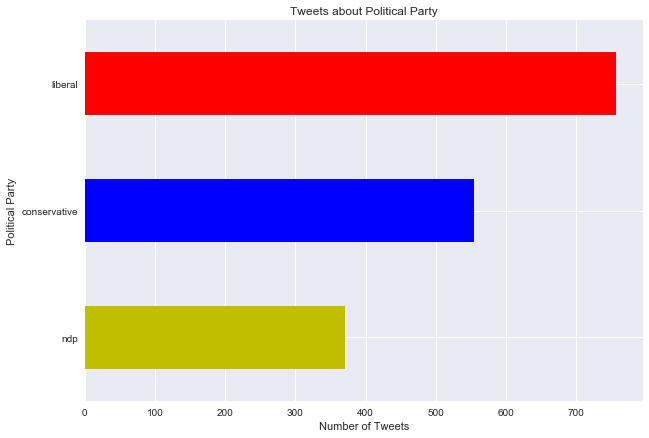

In [14]:
# Plotting by party and their respective color
plt.figure(figsize=(10,7));
tweets[tweets['party'] != 'uncertain'].groupby('party')['tweets'].count().sort_values(ascending = True).plot(kind='barh', color = 'ybr');
plt.title("Tweets about Political Party");
plt.xlabel("Number of Tweets");
plt.ylabel("Political Party");

We can see from the above, the Liberal party was mentioned the most during the election and that they did in fact win. However, this doesn't necessarily mean that the volume of their social buzz was entirely positive! The sentiment analysis will shed some light on this.

We can also observe that the two major forces in the election seem to be the Conservatives and Liberals.

### Visualization 2: Classified Data

Read in the data and drop any columns that aren't directly related to the sentiment analysis:

In [15]:
classified = pd.read_table('classified_tweets.txt', sep=',')
c = classified.drop(['date','query','user', 'id'], axis = 1)
c.head()

,class,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
1,0,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!
2,0,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there."


Clean the classified data using the functions defined earlier in the code.   

Since this file is large and we are processing every tweet, the following cell can take some time (about 2-3 min) to run. For computational reasons, we will removeStop words via the CountVectorizer instead of the clean function. 

In [16]:
classified_domains = find_domains(c, 'text')
classified_domains

c['text'] = c['text'].apply(clean, domain_string=classified_domains, removeStop = False)
c.head()

,class,text
0,0,"@switchfoot - awww, that's a you shoulda got david carr of third day to do ;d"
1,0,is upset that he can't update his facebook by texting and might cry as a result school today blah!
2,0,@kenichan i dived many times for the managed to save 50% the rest go out of bounds
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at i'm why am i here? because i can't see you all over"


In [17]:
c['class'].value_counts()

4    100000
0    100000
Name: class, dtype: int64

There are an equal number of positive and negative tweets in the dataset which validates that the input into the model will be balanced. Additionally, since we will be using a bag-of-words model, it may be interesting to visualize the number of words in each tweet.

In [18]:
# Note this line takes a while to run; basically re-using the function but this time only to exclude stopwords
c['text_stopped'] = c['text'].apply(clean, domain_string=classified_domains, removeStop = True)

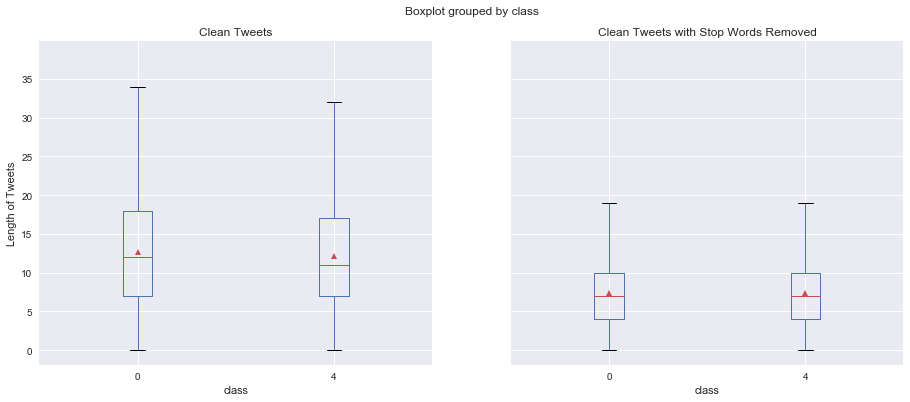

In [19]:
def n_words(text):
    return len(text.split())

# Count number of words in each tweet
c['length'] = c['text'].apply(func=n_words)
c['length_stopped'] = c['text_stopped'].apply(func=n_words)

# Make plot
figure, ax = plt.subplots(ncols=2, figsize = (15,6), sharey=True)
c.boxplot(by='class', column= 'length', ax = ax[0], showmeans=True)
c.boxplot(by='class', column= 'length_stopped', ax = ax[1], showmeans=True)
ax[0].set_title('Clean Tweets')
ax[0].set_ylabel('Length of Tweets')
ax[1].set_title('Clean Tweets with Stop Words Removed');

As one would expect, the length of tweets decreases when we remove stopwards by about 6-7 words (horizontal lines are medians and shapes are means in boxplot). Furthermore, the length of tweets in each class (positive or negative) are similar which indicates that this feature (length of tweets) wouldn't be relevant for discriminating between classes. 

# 3.0 Model Preparation

As with the cleaning method, I will be using NLTK's stop words. It's interesting to note that removing the stopwords doesn't necessarily increase the accuracy of the training set; this can be explored further in the Bonus section.   

The CountVectorizer function, as discussed in class, creates a bag-of-words model where each word corresponds to a feature in the input set and each tweet corresponds to a single training point. In doing so, this method essentially creates a data structure that can be converted to a numpy array for modelling. The code below simply creates a CountVectorizer object that will be applied to our tweets. I will discuss this in more depth at the end of this section.

In [20]:
stop = stopwords.words('english')
count = CountVectorizer(ngram_range=(1,1), stop_words = stop)

The next cell block prepares the data for analysis. First, I shuffle the data to randomize the order in which we train. Since we are using Logistical Regression which relies on Gradient Descent, this can sometimes affect performance. As there is no cross-validation here, this step isn't very critical but is good practice. 

I then convert the text column in the dataframe and its associated classes to numpy arrays and apply the CountVectorizer fit_transformation on the training set x and then transform the testing set into the same dimensional space using the training bag. 

Finally, I split 70% of the feature and target sets as training data leaving the remaining 30% as testing data. 

In [36]:
cs = shuffle(c)

x = np.array(cs.text)
y = np.array(cs['class'])

split = int(0.7 * len(cs))
x_train = x[:split]
x_test = x[split:]

bag_train = count.fit_transform(x_train)
bag_test = count.transform(x_test)

y_train = y[:split]
y_test = y[split:]

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((140000,), (60000,), (140000,), (60000,))

Before moving forward, it is important to discuss some of the modelling considerations with regards to CountVectorizer. First of all, we are opting to ignore all stop words recommended by NLTK. One would imagine this would reduce noise and complexity of our model; however, these individual words can sometimes provide critical hints regarding the context of the sentence. Therefore, it is not immediately clear which approach to take without using a more advanced technique such as cross-validation. This will be discussed further in the Bonus section. 

The second point of significance is that I opted to go with a 1-gram model. Again, this a hyper-parameter that is best set using cross-validation. Using a larger multi-gram model can help capture sentiments contained in a phrase better; however, individual words occur more frequently across many tweets and thus can provide more discriminatory information. With some basic testing I found that test performance degraded with a higher n-gram model. This does make some intuitive sense as tweets are short and concise as opposed other forms of written articles. 

# 4.0 Model Implementation

Fit the logistic regression model using class labels 4 or 0 (since this is a binary classification problem, it is not necessary to encode class label 4 as a 1):

In [42]:
lr = LogisticRegression(C = 10)
lr.fit(bag_train, y_train)
print("Train score:",lr.score(bag_train, y_train),"\nTest Score:", lr.score(bag_test, y_test))

Train score: 0.929835714286 
Test Score: 0.740016666667


The test score above indicates that the model generalized with an acceptable accuracy rate. Ideally, we would like to see a higher score in the 80s. Note that the model is regularized with parameter C = 10. Note that C is inversely proportional with the regularization parameter often described in Machine Learning texts (denoted alpha or lambda); here, a higher value of C describes less bias/regularization in the model. So we would expect that with higher C, our train score may overfit. Additionally, by default, I believe that we are using an l2 loss function which heavily penalizes an incorrect prediction during fitting and is more sensitive to noise.

Applying the model to the unclassified dataset:

In [23]:
bag_tweets = count.transform(np.array(tweets['tweets']))
tweets['sentiment'] = lr.predict(bag_tweets)

In [24]:
tweets.head()

,tweets,party,sentiment
0,living dream. #cameraman #camera #cameraception #camera #cameras #marriott #feet #tommulcair…,ndp,0
1,justin #trudeau's reasons thanksgiving. today's montreal@themoment blog #elxn42 poll #quebec #montreal,liberal,4
2,@themadape butt…..butt…..we’re allergic latex! makes us sneeze #nbpoli #cdnpoli,uncertain,4
3,2 massive explosions peace march #turkey. 30 killed. turkey continues implode violence. #cdnpoli …,uncertain,0
4,#mulcair suggests there’s bad blood #trudeau #ready4change #ndp,ndp,0


Summarizing the results:

In [25]:
tweets.groupby(['party', 'sentiment']).count()

tweets
party        sentiment        
conservative 0          335   
             4          220   
liberal      0          241   
             4          516   
ndp          0          134   
             4          237   
uncertain    0          293   
             4          1050

### Bonus A: Visualization of Tweets by Political Party & Sentiment

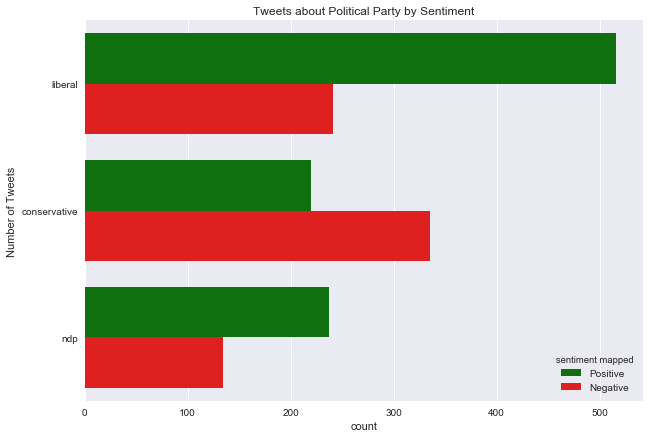

In [26]:
tweets['sentiment mapped'] = np.where(tweets['sentiment'] == 4, 'Positive', 'Negative')
ax, figure = plt.subplots(figsize=(10,7))

sns.countplot(y='party', hue = 'sentiment mapped',
              hue_order = ['Positive', 'Negative'], palette ={'Positive':'g', 'Negative':'r'},
              data=tweets[tweets['party']!='uncertain'],order =['liberal','conservative','ndp'], orient = 'h')

plt.title('Tweets about Political Party by Sentiment');
plt.ylabel('Number of Tweets');

# 5.0 Discussion of Results

For the following discussion, I am assuming that the results of the sentiment analysis are sufficiently accurate.

From the figure above, we can observe that Liberals received both the largest number of tweets and by far the most positive tweets. Comparatively, the NDP did not generate as much buzz despite receiving more positive tweets than negative ones. This matches the political landscape of the 2015 election where the two leading parties were the Conservatives and Liberals. However, one can spectulate that, if the Liberals were not in the 2015 election, NDP may have come out on top over the Conservatives. The most fascinating aspect of the results is that the Conservative party, led by Stephen Harper, was the only group to receive more negative tweets than positive ones. I think this indicates that twitter users were disappointed with the most-recent Conservative party term. The Liberal party not only received twice as many positive tweets as the Conservative party, but also received less negative tweets overall. 

### Bonus B: Trudeau Masked Image Cloud of all Liberal Tweets

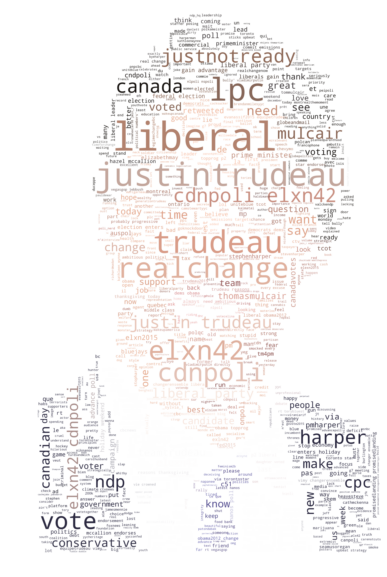

In [27]:
try:
    from PIL import Image
    from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
except:
    ! pip install wordcloud

imageMask = np.array(Image.open('trudeau2.png'))

wc = WordCloud(scale = 4,  background_color='white', max_words=1000, mask=imageMask)
wc.generate(" ".join(tweets[tweets['party'] == 'liberal']['tweets']))

image_colors = ImageColorGenerator(imageMask)   
wc = wc.recolor(color_func=image_colors)

figure = plt.figure(figsize = (15,10))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

From the image cloud, words that stand out include the party leader ("justintrudeau"), his party ("liberal"/"lpc"), comparison to competitors ("harper" and "muclair"), and most interesting two keywords: "realchange" and "justnotready". These two words sum up the major political rhetoric surrounding the election. One side arguing for change, while the other emphasizing that Trudeau (and his brand of change) are not fit to represent Canada. 

Overall, we can take away many things:
1. The Liberals received as many positive tweets as the two other large parties combined implying that it was the most popular party.
2. The Conservative party received the largest number of critical tweets implying that opinion of their party was at a low point after the previous term.
3. The NDP, although positively-received, received lowest number of total tweets implying that they were not considered a major player in this election. 

When you combine these factors, it becomes clear that the Liberal party held an advantage in the 2015 election. The public opinion on Twitter indicates that the public wanted a change and Justin Trudeau's Liberal Party best met the criteria for that change. Their very different policies, with a higher emphasis on Socialism, could be considered the starkest contrast to previous Conservative policies which had a higher emphasis on Economy. Given the excitement on Twitter and Trudeau's eventual win, it seems that Canadians embraced that change.  

### Bonus C: Cross-Validation for Tuning Hyperparameters

Using GridSearch to try and tune hyper parameters. The below defines a PorterStemmer which is an alternate form of tokenization that aims to tokenize words into their basic stems. I will try throwing this into the model to see whether it affects results. 

In [26]:
nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

stop = stopwords.words('english')

def tokenizer(text):
    return text.split()

porter = PorterStemmer()
def tokenizer_porter(text):
    return [porter.stem(word) for word in text.split()]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Zain\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In the below, I will use a Grid Search and a Pipeline to streamline the vectorization and fitting processes. Additionally, rather than use stop words, we will use a technique called Term Frequency-Inverse Document Frequency (tfidf) that weighs each word. This technique downweighs words that occur very frequently (implemented via sklearn). In doing so, this technique can sometimes produce better results than a fixed list of stopwords as it considers which words in the training dataset actually do not contribute much useful information. The GridSearch will ultimately yield the best parameters. 

In [40]:
# Note this cell box can take up to 1 hour to run. 

tfidf = TfidfVectorizer()

param_grid = {
    'vect__stop_words': [stop,None], # Whether the algorithm works better with or without stop words
    'vect__tokenizer':[tokenizer, tokenizer_porter], # what type of tokenization works best
    'clf__penalty': ['l1','l2'], # penalty term l1/l2
    'clf__C':[1.0,10.0, 100.0] # coefficient of penalty
}

lr_tfidf = Pipeline([('vect', tfidf), ('clf', LogisticRegression(random_state=0))])
gs_lr_tfidf = GridSearchCV(lr_tfidf, param_grid, scoring='accuracy', cv = 5, verbose=1, n_jobs=1)
gs_lr_tfidf.fit(x_train,y_train)
gs_lr_tfidf.best_params_

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed: 65.8min
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed: 78.0min finished


{'clf__C': 1.0,
 'clf__penalty': 'l2',
 'vect__stop_words': None,
 'vect__tokenizer': <function __main__.tokenizer>}

In [41]:
print('CV Accuracy:', gs_lr_tfidf.best_score_)
print('Test Accuracy:', gs_lr_tfidf.best_estimator_.score(x_test,y_test))

CV Accuracy: 0.779664285714
Test Accuracy: 0.78005


We see from the above that after tuning hyper parameters, we can achieve a test accuracy of 78%. The biggest difference seems to be the inclusion of stop words in the model, which ultimately raised the test accuracy. This suggests that those stop words were meaningful to the sentiment, or that the NLTK 'english' stop words may have been defined too broadly. 